# Colocation with Tropical Cyclones

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests, xarray, pandas, math, datetime, copy
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

def simple_map(longitudes, latitudes, z=None, zlabel=None, polygon=None, title='', fig=None, figIndex=None, marker=None, secondaries=None):
    if fig:
        ax = fig.add_subplot(figIndex[0], figIndex[1], figIndex[2], projection=ccrs.LambertConformal(cutoff=-60))
    else:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(cutoff=-60))
    gl = ax.gridlines(draw_labels=True,color='black')
    if z:
        s = ax.scatter(longitudes, latitudes, c=z, transform=ccrs.PlateCarree())
        cb = plt.colorbar(s, pad=0.1)
        cb.set_label(zlabel, rotation=270)
    else:
        s = ax.scatter(longitudes, latitudes,transform=ccrs.PlateCarree())
    
    if polygon:
        plt.plot(polygon_lon_lat(polygon)['lon'],polygon_lon_lat(polygon)['lat'],'-k',transform=ccrs.PlateCarree()) 
    if marker:
        plt.plot(marker[0],marker[1],'Xr', transform=ccrs.PlateCarree(), markersize=20)
    if secondaries:
        for sec in secondaries:
            ax.scatter(sec['lon'], sec['lat'],transform=ccrs.PlateCarree(), color=sec['color'], marker='x', s=100)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    plt.title(title, fontdict={'fontsize':20})

API_KEY=''
API_PREFIX = 'https://argovis-api.colorado.edu'

## Search and plot a tropical cyclone

Let's start by downloading Argovis' information for tropical cyclone Harvey in 2017, and plotting it:

In [2]:
tc_param = {
    'startDate': '2017-01-01T00:00:00Z',
    'endDate': '2018-01-01T00:00:00Z',
    'name': 'HARVEY',
    'data': 'wind'
}

tc = requests.get(API_PREFIX + '/tc', params = tc_param, headers={'x-argokey': API_KEY}).json()

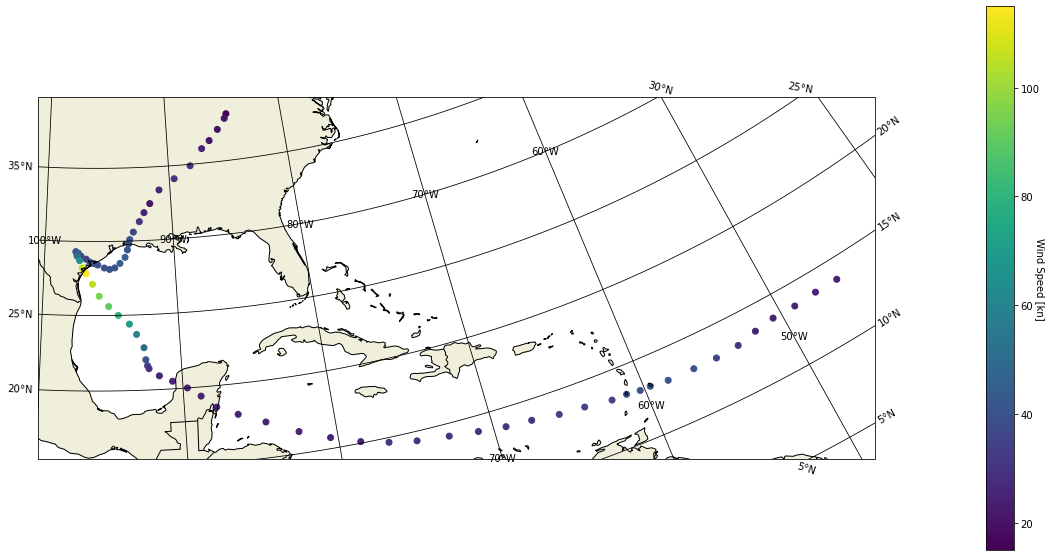

In [3]:
tc_lon = [x['geolocation']['coordinates'][0] for x in tc]
tc_lat = [x['geolocation']['coordinates'][1] for x in tc]
tc_wind = [x['data'][0]['wind'] for x in tc]
simple_map(tc_lon, tc_lat, z=tc_wind, zlabel='Wind Speed [kn]')

## Search and plot colocated Argo data

Next lets see if there were any Argo profiles close by any of Harvey's track points, and add them to our plot:

In [4]:
argo = []

for h in tc:
    colo_argo = {
        'center': str(h['geolocation']['coordinates'][0]) + ',' + str(h['geolocation']['coordinates'][1]),
        'radius': 50,
        'startDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=-6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'endDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'data': 'temperature,salinity',
        'compression': 'array'
    }
    p = requests.get(API_PREFIX + '/argo', params = colo_argo, headers={'x-argokey': API_KEY}).json()
    if 'code' in p or 'code' in p[0]:
        print(p)
        argo.append(None)
    else:
        print('Colo found at', h['geolocation']['coordinates'][0], h['geolocation']['coordinates'][1])
        argo.append(p)

[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 404, 'message': 'No documents found matching search.'}]
[{'code': 

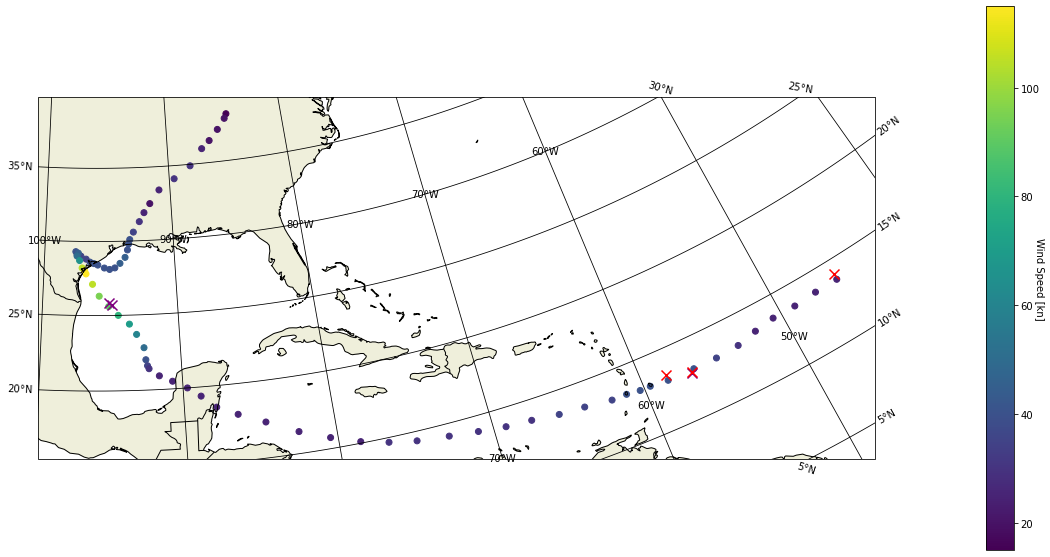

In [5]:
floats = []
nColo = 0
colorBefore = 'red'
colorAfter = 'purple'
for i, colo in enumerate(argo):
    if colo:
        nColo += 1
        hurrtime = datetime.strptime(tc[i]['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ")
        for p in colo:
            ptime = datetime.strptime(p['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ")
            buddy={
                "lon": p['geolocation']['coordinates'][0],
                "lat": p['geolocation']['coordinates'][1],
            }
            if ptime < hurrtime:
                buddy['color'] = colorBefore
            else:
                buddy['color'] = colorAfter
            floats.append(buddy)
simple_map(tc_lon, tc_lat, secondaries=floats, z=tc_wind, zlabel='Wind Speed [kn]')

In the plot above, red X marks profiles collected before the hurricane passed, and purple X marks profiles collected after. Next let's plot the temperatures and salinities found for these profiles, grouping plots by proximate hurricane track point:

In [6]:
def hurrplot(nColo, var, maxpress=150, line=False):
    markers = ['.', 'v', 'P', 'X']
    markernames = ['dot', 'triangle', 'plus', 'x']
    fig, axs = plt.subplots(nColo, figsize=(10,30))
    n = 0
    for i, colo in enumerate(argo):
        if colo:
            hurrtime = datetime.strptime(tc[i]['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ")
            hurrlon = tc[i]['geolocation']['coordinates'][0]
            hurrlat = tc[i]['geolocation']['coordinates'][1]
            annotation = 'Hurricane track longitude: ' + str(hurrlon) + '\nHurricane track latitude: ' + str(hurrlat) + '\nHurricane track timestamp: ' + str(hurrtime)
            np = 0
            maxp = 0
            for p in colo:
                ptime = datetime.strptime(p['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ")
                c = colorBefore
                if ptime > hurrtime:
                    c = colorAfter
                time2hurricane = str(hurrtime.replace(microsecond=0) - ptime.replace(microsecond=0))
                pressure = [level[p['data_keys'].index('pressure')] for level in p['data']]
                maxp = max(maxp, max(pressure))
                d = [level[p['data_keys'].index(var)] for level in p['data']]
                axs[n].scatter(d, pressure, c=[c]*len(pressure), marker=markers[np%len(markers)])
                if line:
                    axs[n].plot(d, pressure, c=c)
                axs[n].set(xlabel=var, ylabel='pressure')
                annotation += '\n\nArgo profile ' + p['_id'] + '\nmarker: ' + markernames[np%len(markers)]  + '\nProfile longitude: ' + str(p['geolocation']['coordinates'][0]) + '\nProfile latitude: ' + str(p['geolocation']['coordinates'][1]) + '\nProfile timestamp: ' + str(p['timestamp'])
                np+=1
            axs[n].set_ylim([0, maxpress])
            axs[n].invert_yaxis()
            axs[n].text(min(d)+0.05*(max(d)-min(d)),0.9*maxpress, annotation)
            n+=1  

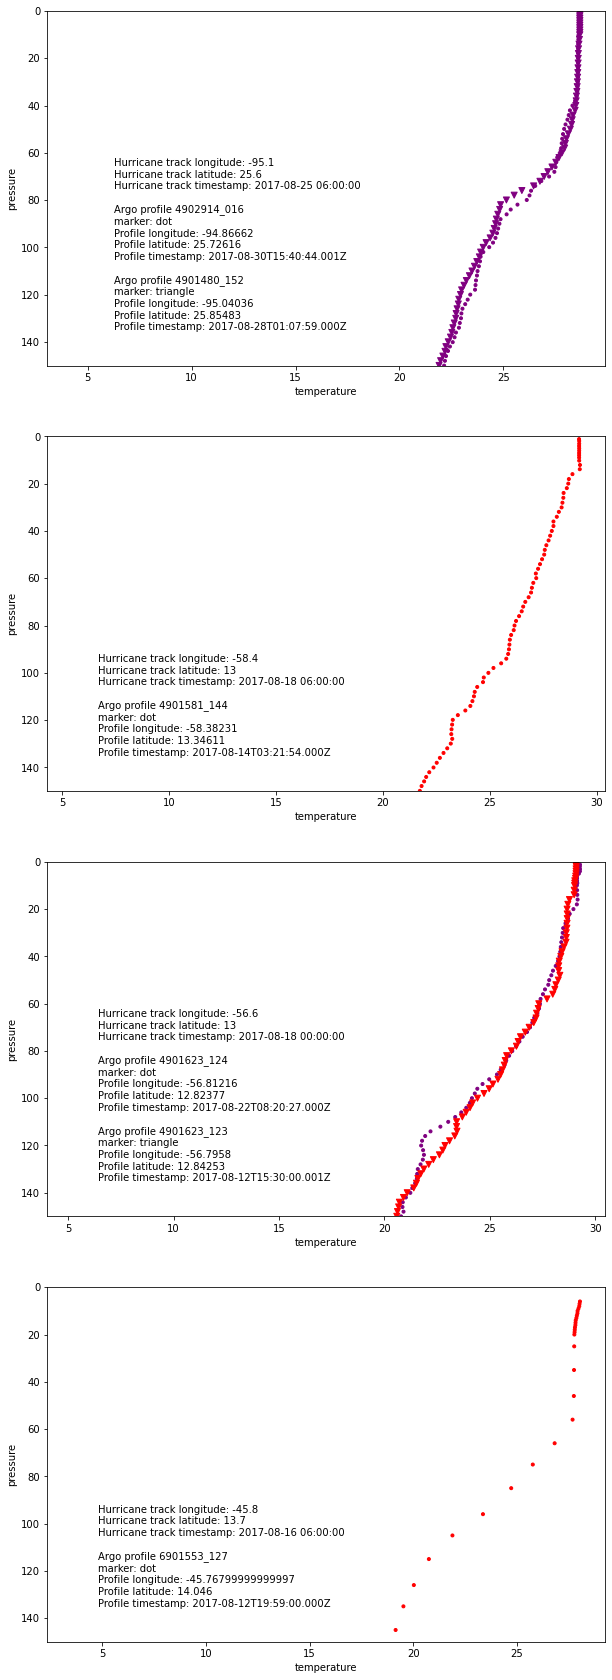

In [7]:
hurrplot(nColo, 'temperature')

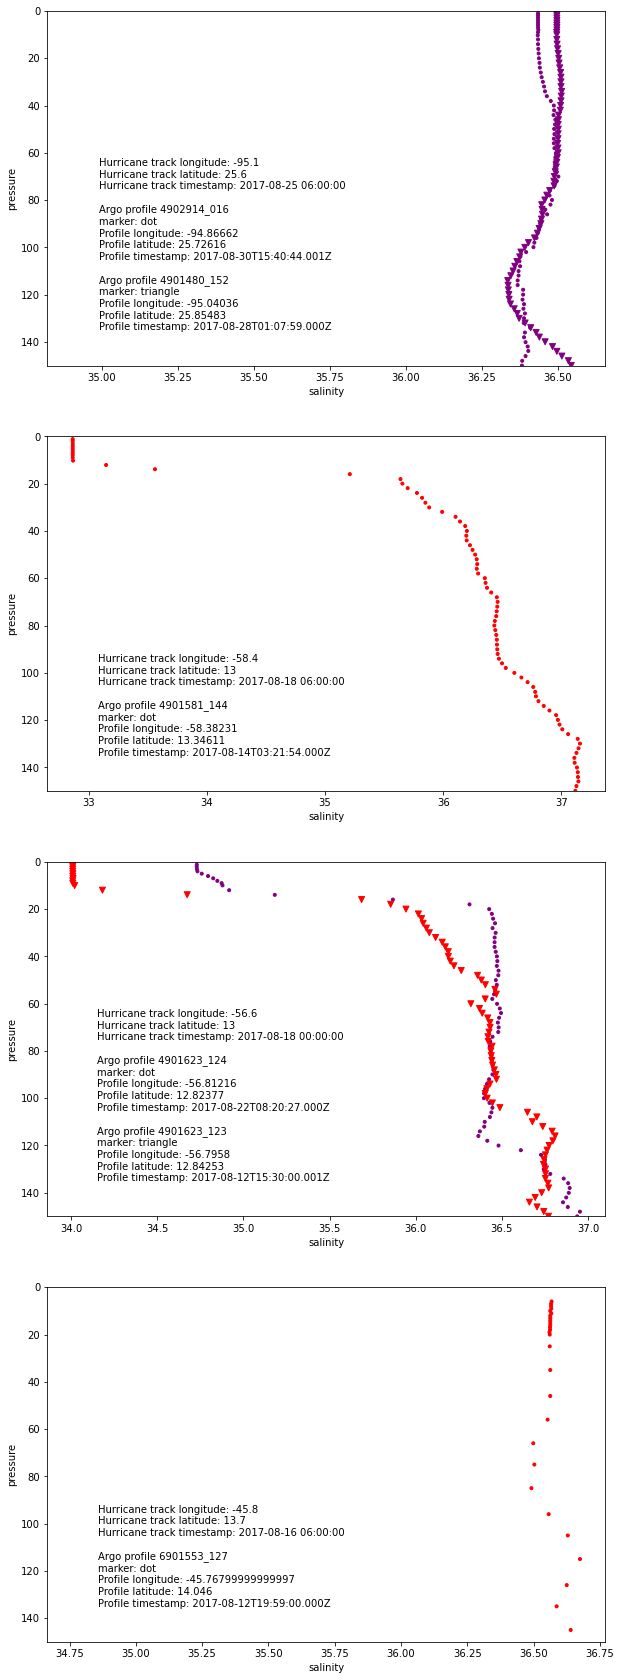

In [8]:
hurrplot(nColo, 'salinity')